# Setup

## Imports

In [14]:
import pandas as pd
import chardet
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [15]:
def import_titles():
    df = pd.read_csv('movie_titles.txt', 
                     encoding="ISO-8859-1", 
                     usecols=[0, 1, 2])
    return df
    
def import_ratings(n):
    df = pd.read_csv('netflix_ratings.txt', 
                     encoding="ascii", 
                     sep=' ',
                     header=None,
                     names=["M_ID", "M_Year", "U_ID", "U_Rating", "U_Date"])
    df = df[df["M_ID"].between(1, n)]
    return df

In [16]:
titles = import_titles()
ratings = import_ratings(500)

In [17]:
print("Shape of titles:",titles.shape)
print("Columns:",titles.columns,"\n")

print("Shape of ratings:",ratings.shape)
print("Columns:",ratings.columns)

Shape of titles: (17770, 3)
Columns: Index(['Movie_ID', 'Year', 'Title'], dtype='object') 

Shape of ratings: (2798704, 5)
Columns: Index(['M_ID', 'M_Year', 'U_ID', 'U_Rating', 'U_Date'], dtype='object')


## Prepare dataframe for PCA

In [18]:
def prepare_PCA_df(n):

    # Create PCA_df directly using pivot
    df = pd.pivot(ratings, values='U_Rating', index='M_ID', columns='U_ID')

    # Drop columns with less than a n of non-NaN values
    thresh = len(df) / n
    df.dropna(axis=1, thresh=thresh, inplace=True)

    # Fill NaN values with 0
    df.fillna(0, inplace=True)

    return df

In [19]:
pre_PCA = prepare_PCA_df(4) # Create df and remove a quarter of NaN-values

## PCA

In [20]:
def do_PCA(datadrame):
    # Normalisation 
    normalized_PCA_df = datadrame - datadrame.mean(axis=0)
    
    # compute the covariance matrix of the standardized data
    covariance_matrix = np.cov(normalized_PCA_df.T)

    # compute the eigenvectors and eigenvalues of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # sort the eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # select the principal components to keep
    total_variance = np.sum(sorted_eigenvalues)
    variance_explained = sorted_eigenvalues / total_variance
    cumulative_variance = np.cumsum(variance_explained)

    # keep the principal components that explain 95% of the variance
    num_components = np.argmax(cumulative_variance >= 0.95) + 1
    #num_components = normalized_PCA_df.shape[1]
    principal_components = sorted_eigenvectors[:, :num_components]

    # project the data onto the selected principal components
    transformed_data = np.dot(normalized_PCA_df, principal_components)
    
    return pd.DataFrame(transformed_data), variance_explained, cumulative_variance

## Make plot

In [30]:
def makeScreePlot(cumulative_variance1, cumulative_variance2):
    if len(cumulative_variance1) > len(cumulative_variance2):
        cumulative_variance2 = np.append(cumulative_variance2, 1)
    if len(cumulative_variance2) > len(cumulative_variance1):
        cumulative_variance1 = np.append(cumulative_variance1, 1)
    
    fig = plt.figure(figsize=(10,10))
    component_number2 = np.arange(len(cumulative_variance2))
    component_number1 = np.arange(len(cumulative_variance1))
    component_number = np.arange(len(cumulative_variance))
    plt.plot(component_number2, cumulative_variance2, 'o-', linewidth=2)
    plt.plot(component_number1, cumulative_variance1, 'o-', linewidth=2)
    plt.plot(component_number, cumulative_variance, 'o-', linewidth=2)
    plt.plot(component_number1+component_number2, (cumulative_variance1 + cumulative_variance2)/2, 'o-', linewidth=2)
    plt.legend()
    plt.xlabel('Component number')
    plt.ylabel('Variance')
    plt.title('Scree Plot')
    plt.show()

## Baseline one dataset

In [22]:
onePCA, variance, cumulative_variance = do_PCA(pre_PCA)
display(onePCA)

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,0.661080,-1.190004,-3.173268,0.133291,-1.174563,-1.642050,3.879779,0.266048,-0.968725,5.590568,...,-2.154025,1.817922,1.511537,0.576577,-0.516643,0.848111,-3.311118,-1.084560,-0.308493,0.186348
1,-5.204676,1.471293,-1.383176,1.781137,0.610600,0.968898,0.030702,0.488112,0.521751,0.418734,...,-0.229087,0.586087,-0.550501,-0.368330,0.920374,0.161761,0.263997,0.762879,-0.044593,0.212447
2,1.642289,-6.143146,3.914321,-0.082383,3.401981,1.567582,0.243515,-1.718900,-1.089269,-0.970254,...,1.256848,-0.038232,-1.105088,0.450104,-3.626537,0.159570,0.626423,0.789559,2.687654,0.206318
3,-6.104408,-0.048418,-0.476455,0.055741,-0.776943,-0.278967,-0.268459,-0.344925,-0.508780,-0.567231,...,-0.231591,0.632326,-0.071741,-0.201850,-0.829047,-0.645775,-0.847398,-0.322616,0.871924,0.677429
4,-3.797008,2.105373,-0.669235,-0.065920,2.209283,-0.392270,1.086059,1.963380,-1.538563,1.453653,...,-0.046214,0.276580,-0.242456,-0.299587,-0.020524,-0.683437,0.217193,0.996090,0.545167,-1.150358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-5.726406,1.703361,-0.849463,0.799656,-1.230859,0.702149,-0.060258,-0.757908,1.725790,-0.163327,...,0.363106,-0.117070,-0.110197,-0.024135,-0.125893,0.819694,-0.955045,0.157326,0.270199,0.735800
496,-1.936991,-4.546374,0.126931,-0.316129,-1.181818,-1.563495,-0.485917,1.055289,3.795496,-0.827178,...,0.774242,0.283092,-0.584765,-1.349906,-0.884449,0.885024,-0.730641,0.536837,0.009430,1.092861
497,-6.277217,-0.599357,0.422103,-2.540633,-3.682342,1.134339,1.160738,-1.339314,0.685377,-0.846438,...,1.140384,0.992292,2.090670,-0.063839,1.740258,1.365003,0.922785,-1.739269,0.024829,-1.183733
498,6.997943,0.464158,-0.636984,-5.526613,-0.549820,-1.604642,-0.803876,0.284566,-0.236875,1.451385,...,0.779073,0.859071,-0.197060,-0.000617,-0.435663,1.151685,-0.145732,-0.081623,-1.431995,0.537599


## Uncorrelated PCA dataframes

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.483385,-1.574123,2.661245,2.276674,-3.283522,2.590626,0.858178,2.410833,-2.775346,0.372444,...,1.382462,0.178120,-1.224044,1.730874,0.103345,1.975272,-1.879007,-1.005769,-0.211213,1.171026
1,-4.766807,0.271768,0.044809,0.421963,0.433614,-0.629026,0.193027,0.368495,0.167958,-0.255886,...,-0.060476,-0.278286,0.201610,-0.600844,-0.210900,0.748572,0.265460,1.209955,-0.379234,0.584811
2,0.987577,-4.546462,-1.596311,-4.837517,-0.167838,-0.947707,1.705757,0.003598,-0.056536,0.342059,...,1.163722,-1.630186,0.646309,0.624860,-0.549158,0.668809,2.224108,-0.166021,2.533516,1.184933
3,-4.101608,0.022484,0.463794,0.956680,0.083218,-0.672922,0.262183,-0.534805,-0.725591,0.530189,...,0.099348,0.053688,0.760439,-0.431391,0.213301,1.507732,0.121687,0.130369,1.094284,0.365438
4,-3.383174,1.955715,0.098784,-0.210003,-0.759653,0.845733,-0.996715,1.768485,1.464237,-0.871122,...,0.724186,0.203944,-0.679443,-0.555562,-0.397730,0.087290,0.688008,0.993911,-0.436749,1.079240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-4.685093,0.478948,-0.186786,0.190737,0.509599,-0.050607,0.415202,-0.808407,-0.541815,0.240584,...,0.193691,-0.254096,-0.711565,0.120715,0.334747,0.011851,0.447030,0.187222,-0.018207,-0.014806
496,-0.586096,-4.468874,2.412566,0.687255,1.934497,-0.762174,-1.868327,-0.285368,1.369045,0.167308,...,-1.508769,-2.073976,-0.380266,0.111786,-0.702700,0.241277,-0.251670,0.387638,0.699422,-0.187721
497,-3.880725,-0.638265,0.934222,0.190972,-1.404797,-0.010748,0.856560,-1.190363,-0.781351,-0.777897,...,-0.515024,0.275578,0.262418,-0.201255,-0.621610,0.236266,-0.689997,0.722418,-2.926721,-0.642054
498,3.620985,1.233448,3.456682,-2.336982,-2.071478,0.347124,-2.017690,-1.293540,-2.028469,2.140494,...,-1.055089,0.064187,-0.915041,0.471350,-0.329504,-0.503437,-1.708079,0.211700,-0.423422,-0.447887


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.526436,0.151696,-2.581266,-0.697627,-1.829819,-1.108556,-0.398293,1.800158,-1.185083,2.414726,...,2.476722,0.664751,-1.296946,-0.332735,-3.413200,-0.244399,-1.279585,0.244998,1.331062,-0.374427
1,-2.413920,1.520597,-2.082305,-0.401899,-1.047858,1.430418,2.470724,1.608359,0.431285,-1.030620,...,0.908515,1.109334,0.036547,0.350220,0.760363,-0.161180,0.421894,0.140224,-0.247003,0.550578
2,1.308753,-5.016001,1.096371,1.912581,0.177943,2.217077,-0.280501,-1.845468,1.010159,-1.020367,...,-1.091067,1.709020,0.575070,0.382515,-1.094096,0.484200,0.256976,0.247772,-0.801977,-0.459427
3,-4.603384,0.094866,-0.075104,0.083286,0.195402,0.486119,-0.037044,0.281090,0.534581,0.551974,...,0.318807,-0.089294,0.133963,-0.055948,0.016799,0.344821,-0.472453,-0.609603,-0.404495,0.379100
4,-1.912283,1.150634,-1.153155,2.803639,-0.673918,0.938076,1.089286,0.590160,-0.801714,0.696162,...,-0.642465,0.488800,-0.060371,1.003050,1.648522,0.885549,-1.714744,0.014666,-0.106609,-0.873824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-3.296766,1.705478,-0.686569,-2.482625,-0.670608,-0.312074,0.144591,0.882616,0.772805,-0.530946,...,0.743808,0.040293,-0.583769,0.130097,0.356980,-0.270887,0.478319,0.863745,0.125546,-0.047179
496,-2.301476,-1.421701,1.494928,-1.703994,-0.448387,-0.801405,-0.168239,-0.920500,-0.293058,3.025168,...,-1.100016,1.275937,1.027638,1.838218,-1.516327,-1.886152,-0.489241,-1.036407,0.437548,-1.411399
497,-5.139353,0.097094,2.073024,-3.084743,-0.631693,0.325753,-0.560490,-0.864933,-0.143933,0.774864,...,-0.451982,-1.374591,0.975128,-1.071194,0.383309,1.688406,1.151992,0.728371,-0.950995,-0.209423
498,6.424219,0.195248,2.945363,-0.403376,1.092176,-1.049340,-1.091420,-0.563229,0.206420,3.173488,...,1.034732,-0.227710,-0.635060,-1.805488,-1.694272,-0.248970,0.536519,-1.128054,1.687412,1.339133


No handles with labels found to put in legend.


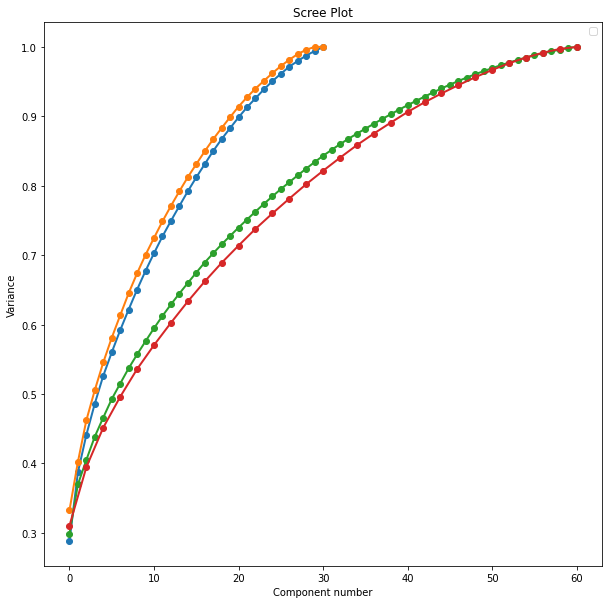

In [31]:
# Calculate the midpoint for column splitting
midpoint = len(pre_PCA.columns) // 2

# Split the dataframe into two halves
uncorr_1 = pre_PCA.iloc[:, :midpoint]  # First half of columns
uncorr_2 = pre_PCA.iloc[:, midpoint:]  # Second half of columns

# Calculate respective PCAs for each dataframe
uncorr_pca_1, uncorr_variance1, uncorr_cumulative_variance1 = do_PCA(uncorr_1)
uncorr_pca_2, uncorr_variance2, uncorr_cumulative_variance2 = do_PCA(uncorr_2)

display(uncorr_pca_1)
display(uncorr_pca_2)

makeScreePlot(uncorr_cumulative_variance1, uncorr_cumulative_variance2)

## Correlated by 40% similar columns

42 18
(500, 42)
(500, 43)


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.575946,1.662117,-2.018573,-0.481747,3.200026,-1.534617,-0.282416,2.361064,3.667286,0.471111,...,1.597922,-1.971772,-2.770182,-0.820318,2.232748,-1.166478,0.162122,-1.481802,-3.462451,-0.020085
1,4.462011,-1.333969,-0.410007,-1.705644,-1.024999,0.615527,-0.009417,0.870689,0.144720,-0.714108,...,-2.571925,-0.777133,0.005736,0.912318,-0.262385,-0.710446,-0.475357,-0.693787,-0.285340,0.677709
2,-1.049443,5.487590,3.283061,2.962728,-3.747992,0.505007,-2.028543,0.633003,-0.542707,-1.064922,...,-1.090998,0.190492,-0.371852,0.385407,-0.977230,1.205948,-0.017737,2.318431,-0.672797,0.330644
3,5.044559,-0.141710,-0.346288,-0.394926,0.686308,-0.433259,-0.132879,-1.064935,-0.467384,0.225230,...,-0.342941,-0.347664,-0.439103,-0.366439,0.739653,-0.555894,0.017673,1.078258,-0.853742,-0.219943
4,3.378408,-2.545857,-0.330331,0.722296,-0.117604,0.399412,0.741815,2.785326,-0.219161,0.922157,...,-1.368081,0.306555,-0.486170,0.821982,-1.042940,-0.446688,-0.874586,-0.252595,-0.375402,-0.037813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4.974034,-0.857186,-0.348524,-0.984240,-0.302781,0.939057,0.120155,-0.482334,0.273359,-0.593038,...,-0.002306,-0.642203,0.283070,-1.099516,0.037868,-0.242213,0.005887,0.150647,-0.088511,0.247031
496,0.805210,4.975437,-0.644572,0.102303,1.567563,1.566345,3.145412,-0.394182,-1.306938,-1.010068,...,1.509150,-0.988150,1.073850,0.552699,-0.384857,-1.313735,0.117095,2.315579,1.056769,1.303612
497,5.306004,0.141779,-0.228917,0.872701,1.218891,-2.587454,-1.218292,-2.122571,0.855320,-1.591712,...,0.292063,-0.164020,-0.272932,0.375177,-0.163605,-1.285591,-0.072287,-2.430607,0.635509,-1.800151
498,-4.483829,-0.855166,-2.492399,4.303613,1.328889,-0.461318,0.899727,-0.312901,-0.134414,1.165262,...,2.841499,-0.727580,-0.395367,0.554783,1.708165,-0.398541,0.104039,0.510819,0.721873,-1.219900


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,-1.572046,0.102444,3.334156,-0.866441,-1.011048,-1.584129,-0.064041,-2.036485,-0.236241,2.278008,...,-0.945728,2.140772,-2.786809,-2.286389,0.912907,-1.702658,0.770092,0.428382,-1.187428,0.259148
1,-3.674553,1.304231,2.287411,0.418939,0.944503,0.657262,1.485545,-0.186467,-0.588498,0.498185,...,0.454282,-0.938272,0.981273,-0.446242,0.007300,0.502500,0.913274,0.393254,0.476416,-0.108483
2,1.180672,-5.357779,-1.376749,-0.523269,2.594218,-0.009878,-1.557338,2.044052,0.203302,0.563235,...,2.374407,0.768118,-0.765164,1.452058,0.270810,1.805043,0.022009,-0.762959,0.304464,-1.903964
3,-5.671761,-0.027751,0.144254,0.220949,-0.219228,-0.152143,-0.464725,0.504174,-0.205087,-0.157199,...,-0.211746,0.082181,0.316630,-0.404340,-0.197566,0.137553,-0.579707,0.319648,-0.449919,0.504482
4,-2.403279,1.941066,0.687409,-2.638823,2.014332,-0.178376,0.499942,0.152674,1.377100,-0.857623,...,1.585986,-0.440742,1.999068,0.775586,0.055687,-0.312519,-1.000754,-0.488742,-0.323727,-0.571025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-4.271335,1.776391,1.027683,1.967001,-0.829001,0.059858,0.903297,-0.475647,-1.259069,0.295121,...,-0.026490,0.457529,0.011254,1.179356,-0.581893,0.033408,0.818645,0.309038,-0.089806,-0.184199
496,-2.417757,-3.284945,-1.449300,0.359874,-2.902826,0.268027,2.292305,-0.087109,-0.479881,-1.442621,...,1.453108,1.015477,0.459450,1.264424,1.800273,-0.568104,1.201717,-1.451637,-1.396393,0.699173
497,-5.570702,0.156838,-1.890001,3.333191,-0.821477,-2.048228,0.079727,-0.003804,-0.817802,0.454048,...,-1.392830,1.394196,0.782868,0.069090,-1.071696,1.461219,0.715101,1.001728,-0.049816,0.255682
498,5.877137,0.476459,-2.898559,-0.852908,-1.587726,-0.213334,-0.906620,-1.596339,0.933790,2.774134,...,-1.832164,2.543233,-1.030563,0.975063,0.577511,-0.232079,0.276363,-0.825122,0.883612,1.958890


No handles with labels found to put in legend.


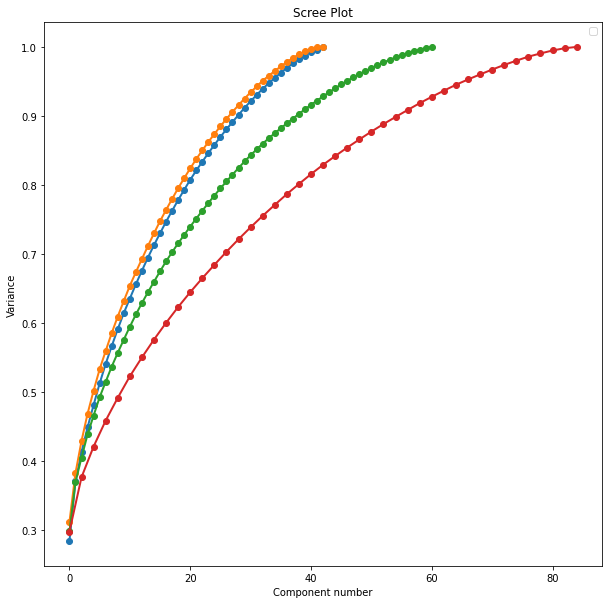

In [32]:
# Find the number of columns in the dataset
nr_columns = pre_PCA.shape[1]

# Split the dataframe 30% in each set and 40% shared for both
persent30 = nr_columns*0.3
persent40 = nr_columns*0.4

if persent30 % 1 == 0:
    splitpoint1 = int(persent30) + int(persent40)
    splitpoint2 = int(persent30) + 1

else:
    splitpoint1 = int(persent30) + int(persent40)
    splitpoint2 = int(persent30)
    
print(splitpoint1, splitpoint2)

corr3040_1 = pre_PCA.iloc[:, :splitpoint1]  # First half of columns
corr3040_2 = pre_PCA.iloc[:, splitpoint2:]  # Second half of columns
print(corr3040_1.shape)
print(corr3040_2.shape)


# Calculate respective PCAs for each dataframe
corr3040_pca_1, corr3040_variance1, corr3040_cumulative_variance1 = do_PCA(corr3040_1)
corr3040_pca_2, corr3040_variance2, corr3040_cumulative_variance2 = do_PCA(corr3040_2)

display(corr3040_pca_1)
display(corr3040_pca_2)

makeScreePlot(corr3040_cumulative_variance1, corr3040_cumulative_variance2)

## Correlated by random choice

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.759674,-1.824311,2.436936,0.581307,1.346696,2.120925,-1.044936,2.508000,0.385716,1.151520,...,-0.234583,0.702313,-1.277423,0.796803,0.374143,2.801033,0.305175,1.763714,-1.874945,2.687086
1,4.227530,0.655808,1.563025,-0.560108,0.361034,0.753259,-1.039326,-0.372752,0.225258,-0.182267,...,-0.466391,-0.107040,-0.540313,0.628522,0.083219,0.476835,-0.135286,-0.263841,0.065566,0.549710
2,0.297203,-4.555391,-1.903845,-1.604504,0.330948,-0.407213,1.668497,-1.330160,-0.534563,-1.714951,...,1.613248,-2.598816,-0.539666,1.100431,-2.282813,-0.467897,-0.589822,0.148417,-0.357973,-1.629745
3,5.184635,0.028997,0.109575,0.345762,-0.272685,-0.340947,0.337057,-0.254737,0.446046,0.252395,...,-0.427941,0.356804,-0.235946,0.094223,0.404067,0.157806,0.146122,0.037364,0.273774,0.062611
4,2.719762,1.747969,-0.286540,-1.643747,1.373405,1.208570,1.873165,1.004671,0.247559,1.303479,...,0.881483,-0.022152,-0.049226,1.039704,0.214427,-1.243625,-0.407343,-0.382534,2.593787,-0.777105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4.542350,1.121493,1.165649,1.037601,0.294573,-0.839154,-2.748037,-0.286159,0.305247,-0.613682,...,0.880969,-0.007662,-0.706149,1.124806,0.083970,0.659582,-1.345558,-0.706541,0.073377,0.109093
496,1.554518,-2.169093,-0.496461,3.522373,0.347763,0.455748,-1.734892,-0.946637,1.371069,2.114269,...,0.170689,-0.456721,-1.254320,-0.241134,-3.598997,-1.108293,-0.236790,0.164601,0.444932,-0.472020
497,5.118883,0.115415,-1.312713,1.285374,-0.060925,-1.993005,-1.484200,0.260477,0.421694,-0.168850,...,-0.805275,0.974003,-0.677372,-0.111013,0.104427,-0.652118,-0.667066,0.921668,1.024601,1.301472
498,-4.617258,1.018797,-3.294016,0.374458,-2.522097,1.591100,-0.653369,0.477591,-0.974342,0.464151,...,1.022022,1.939386,-0.327449,0.801521,-0.744993,1.699168,1.123570,0.931100,0.562372,-1.124831


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.029393,1.902146,1.334778,-0.146217,0.811437,1.558750,1.690670,-0.487855,-2.271979,0.974734,...,-0.213427,-2.701801,-0.533623,2.131058,-1.222772,-1.009515,-1.393604,-0.587969,-1.660740,0.504978
1,-2.694198,-1.246308,0.708531,2.582554,-1.919732,0.239908,0.424324,1.183868,0.561407,-0.170836,...,-0.457741,0.612900,-0.321868,-0.840889,0.870392,0.560195,0.945955,0.306523,-0.289832,-0.087632
2,2.808869,3.044941,-3.631127,0.502862,0.651587,-1.491430,-0.910149,-0.253291,2.293017,0.702749,...,0.010146,0.269408,-1.759562,-1.216912,0.311914,0.305550,-0.040491,-3.618646,-1.244199,-0.857776
3,-4.178028,0.021663,0.092443,-0.516016,0.061124,-0.097819,-0.182456,0.491259,-0.478536,0.636425,...,-0.488331,-0.713641,0.095259,-0.277740,0.212563,0.024170,0.556977,-1.559610,0.089089,-0.598402
4,-1.690068,-0.975748,1.125020,2.546073,0.929127,-0.152593,1.801858,0.375825,0.371727,0.143506,...,0.612310,1.670443,0.846874,-1.898568,0.792004,-1.247424,-0.442045,-0.512434,0.007602,0.449224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-4.184920,-1.240332,0.236108,-0.254492,-1.509647,0.711538,-0.732114,-0.328736,-0.616380,1.043388,...,-1.386789,0.122701,-0.278479,-1.007063,-0.012924,0.895614,0.005199,-0.375954,-0.228586,0.452036
496,-2.938353,0.509851,0.380759,-1.995892,-0.692991,0.787781,1.542922,-1.930520,-1.289496,0.811094,...,1.601835,1.089906,-1.727182,0.529871,0.231758,-0.367834,1.127256,-0.790715,0.960191,1.154112
497,-5.320852,-0.071822,-0.180585,-3.696376,-1.432026,-0.319058,-0.470168,-1.584486,-0.035900,-0.038860,...,-0.421475,0.558480,1.060532,-0.701046,-0.806811,-0.932247,-0.203562,1.513310,-0.599251,-0.098310
498,4.370245,-0.521536,3.056812,-3.632397,2.091146,2.247471,-0.315860,-0.625147,-1.664365,1.855700,...,-1.497808,0.319374,-1.067350,1.415628,-0.146805,0.325032,0.952111,0.105720,-0.095136,0.586289


No handles with labels found to put in legend.


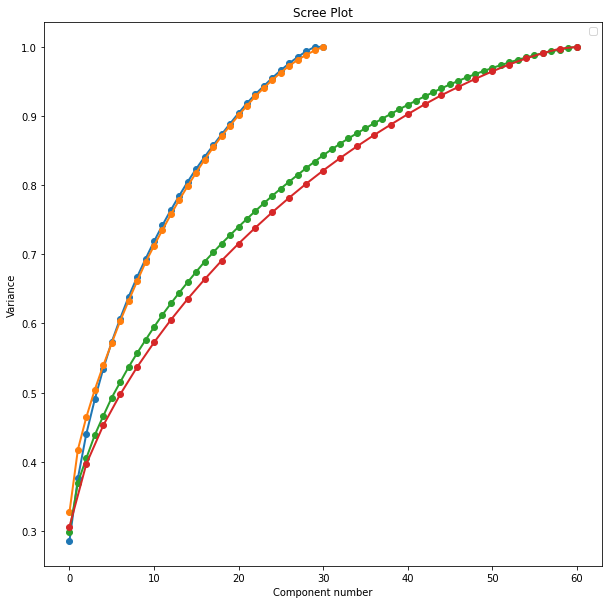

In [33]:
# Find the number of columns in the dataset
nr_columns = pre_PCA.shape[1]

# Choose random columns
all_columns = pre_PCA.columns
random_columns1 = np.random.choice(all_columns, size=31, replace=False)
random1_df = pre_PCA[random_columns1]
random_columns2 = np.random.choice(all_columns, size=30, replace=False)
random2_df = pre_PCA[random_columns2]

# Calculate respective PCAs for each dataframe
random_pca_1, random_variance1, random_cumulative_variance1 = do_PCA(random1_df)
random_pca_2, random_variance2, random_cumulative_variance2 = do_PCA(random2_df)

display(random_pca_1)
display(random_pca_2)

makeScreePlot(random_cumulative_variance1, random_cumulative_variance2)